
# Elemento `LinearTriangle`

El elemento `LinearTriangle` es un elemento finito bidimensional con coordenadas locales y globales, caracterizado por una función de forma lineal. Puede ser utilizado para problemas de esfuerzo y deformación plana. Este elemento tiene un módulo de elasticidad $E$, una relación de Poisson $\nu$ y un espesor $t$. Cada triangulo tiene tres nodos con dos grados de libertad en el plano (`ux` y `uy`), las coordenadas globales de estos nodos se denotan por $(x_i,y_i)$, $(x_j,y_j)$ y $(x_m,y_m)$ (como se muestra en la figura). El orden de los nodos para cada elemento es importante y deben listarse en sentido antihorario comenzando desde cualquier nodo.

<img src="src/linear-triangle-element/linear_triangle_element.PNG" width="200px">

La matriz de rigidez por elemento viene dada por:

$$ [k] = tA[B]^T[D][B] $$

Donde $A$ es el área del elemento dada por:

$$ A = \frac{1}{2} \left( x_i(y_j-y_m) + x_j(y_m - y_i) + x_m(y_i - y_j) \right) $$

y $[B]$ es la matriz dada por:

$$
[B] = \frac{1}{2A}
\begin{bmatrix}
\beta_i & 0 & \beta_j & 0 & \beta_m & 0 \\
0 & \gamma_i & 0 & \gamma_j & 0 & \gamma_m \\
\gamma_i & \beta_i & \gamma_j & \beta_j & \gamma_m & \beta_m \\
\end{bmatrix}
$$

Donde $\beta_i$, $\beta_j$, $\beta_m$, $\gamma_i$, $\gamma_j$ y $\gamma_m$ están dados por:

$$ \beta_i = y_j - y_m $$
$$ \beta_j = y_m - y_i $$
$$ \beta_m = y_i - y_j $$
$$ \gamma_i = x_m - x_j $$
$$ \gamma_j = x_i - x_m $$
$$ \gamma_m = x_j - x_i $$

Para el caso de esfuerzo plano la matriz $D$ viene dada por:

$$
[D] = \frac{E}{1-\nu^2}
\begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & \frac{1-\nu}{2} \\
\end{bmatrix}
$$

Los esfuerzos en cada elemento se calculan mediante:

$$ \{\sigma\} = [D][B]\{u\} $$

Donde $\sigma$ es el vector de esfuerzos en el plano, es decir:

$$ \sigma = \begin{Bmatrix} \sigma_x \\ \sigma_y \\ \tau_{xy} \end{Bmatrix} $$

y $u$ el vector de desplazamientos en cada nodo del elemento:

$$ \{u\} = \begin{Bmatrix} ux_i \\ uy_i \\ ux_j \\ uy_j \\ ux_m \\ uy_m \end{Bmatrix}$$

## Ejemplo 1. Caso simple 
En este ejemplo vamos a resolver el caso más simple: un elemento triangular fijo en dos de sus nodos y con una fuerza aplicada en el tercero.

Importamos **NuSA** e indicamos que usaremos el modo "inline" de matplotlib en este notebook

In [1]:
%matplotlib inline
from nusa import *

Definimos algunas propiedades a utilizar:

In [2]:
E = 200e9 # Módulo de elasticidad
nu = 0.3 # Relación de Poisson
t = 0.1 # Espesor

Creamos los nodos y el elemento:

In [3]:
n1 = Node((0,0))
n2 = Node((1,0.5))
n3 = Node((0,1))
e1 = LinearTriangle((n1,n2,n3),E,nu,t)

Creamos el modelo y agregamos los nodos y elementos a este:

In [4]:
m = LinearTriangleModel("Modelo 01")
for n in (n1,n2,n3): m.add_node(n)
m.add_element(e1)

Aplicamos las condiciones de carga y restricciones:

In [5]:
m.add_constraint(n1, ux=0, uy=0)
m.add_constraint(n3, ux=0, uy=0)
m.add_force(n2, (5e3, 0))

En este punto podemos graficar el modelo con las condiciones impuestas, para esto utilizamos el método `plot_model`:

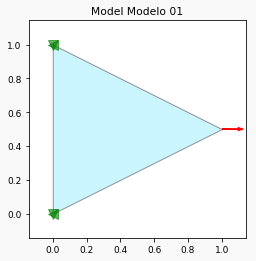

In [6]:
m.plot_model()

Finalmente resolvemos el modelo:

In [7]:
m.solve()

Podemos consultar los desplazamientos nodales:

In [8]:
for n in m.get_nodes():
    print n.ux, n.uy

0 0
4.55e-07 0.0
0 0


Además, utilizar las herramientas de postproceso para graficar el campo de desplazamientos en el elemento:

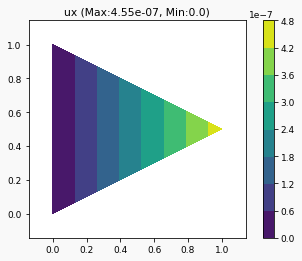

In [9]:
m.plot_nsol('ux')

## Placa simple, utilizando NuSA Modeler

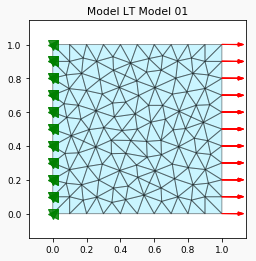

In [10]:
import nusa.mesh as nmsh

md = nmsh.Modeler()
BB, ES = 1, 0.1
a = md.add_rectangle((0,0),(BB,BB), esize=ES)
nc, ec = md.generate_mesh()
x,y = nc[:,0], nc[:,1]

nodos = []
elementos = []

for k,nd in enumerate(nc):
    cn = Node((x[k],y[k]))
    nodos.append(cn)
    
for k,elm in enumerate(ec):
    i,j,m = int(elm[0]),int(elm[1]),int(elm[2])
    ni,nj,nm = nodos[i],nodos[j],nodos[m]
    ce = LinearTriangle((ni,nj,nm),200e9,0.3,0.25)
    elementos.append(ce)

m = LinearTriangleModel()
for node in nodos: m.add_node(node)
for elm in elementos: m.add_element(elm)
    
# Aplicando condiciones de frontera en los extremos
minx, maxx = min(x), max(x)
miny, maxy = min(y), max(y)

P = 100e3/((BB/ES)+1)

for node in nodos:
    if node.x == minx:
        m.add_constraint(node, ux=0, uy=0)
    if node.x == maxx:
        m.add_force(node, (P,0))

m.plot_model()
m.solve()

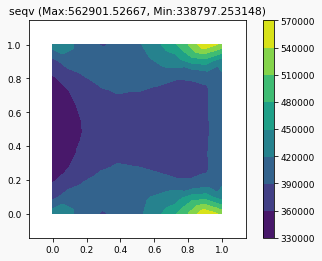

In [11]:
m.plot_nsol("seqv")

## Placa con agujero

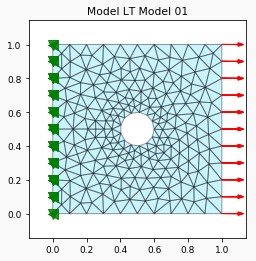

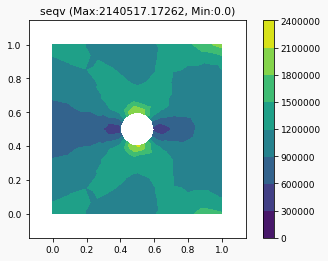

In [20]:
import nusa.mesh as nmsh

md = nmsh.Modeler()
a = md.add_rectangle((0,0),(1,1), esize=0.1)
b = md.add_circle((0.5,0.5), 0.1, esize=0.05)
md.substract_surfaces(a,b)
nc, ec = md.generate_mesh()
x,y = nc[:,0], nc[:,1]

nodos = []
elementos = []

for k,nd in enumerate(nc):
    cn = Node((x[k],y[k]))
    nodos.append(cn)
    
for k,elm in enumerate(ec):
    i,j,m = int(elm[0]),int(elm[1]),int(elm[2])
    ni,nj,nm = nodos[i],nodos[j],nodos[m]
    ce = LinearTriangle((ni,nj,nm),200e9,0.3,0.1)
    elementos.append(ce)

m = LinearTriangleModel()
for node in nodos: m.add_node(node)
for elm in elementos: m.add_element(elm)
    
# Aplicando condiciones de frontera en los extremos
minx, maxx = min(x), max(x)
miny, maxy = min(y), max(y)

for node in nodos:
    if node.x == minx:
        m.add_constraint(node, ux=0, uy=0)
    if node.x == maxx:
        m.add_force(node, (10e3,0))

m.plot_model()
m.solve()
m.plot_nsol("seqv")